In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
from matplotlib.patches import Rectangle

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import gc # Free up memory

import scipy.stats
import scipy.special
import scipy.optimize

import copy

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Reading in data

In [2]:
def get_predictions(df, t, start):
    # Previously returned as np array, changed to series for compatability with filtered datasets
    try:
        return df.loc[df.start==start, :].loc[t, 'value']
    except:
        return df.loc[(df.start==start)&np.in1d(df.index, t), 'value']

def ranking(df, ax=None, kwargs={}):

    t = df.index.unique()
    df["Rank"] = np.nan
    for start in df.start.unique():
        # Get ALL values from this start value (including observations-rank should be consistent if predictions are accurate)
        pred = get_predictions(df, t, start)

        ranks = scipy.stats.rankdata(pred) 
        df.loc[df.start==start, 'Rank'] = ranks

    # Optional plotting of results
    if ax is not None:
        rank_df = copy.deepcopy(df)
        rank_df = rank_df.assign(value=rank_df.Rank)
        plot_residuals(rank_df, ax, **kwargs)

def MAEs(df):
    # Get errors of data
    df["Observed"] = df.index
    df["Observed"] = df["period"].map(df.set_index("period").loc[df.start==df.start.max(), 'value'])

    ranking(df)
    df["Observed Rank"] = df["period"].map(df.loc[df.start==df.start.max(), 'Rank'])
    
    df = df.assign(error=(df.value-df.Observed), rank_error = (df.Rank-df["Observed Rank"]))
    df['Absolute Error'] = abs(df.error)
    df['Absolute Rank Error'] = abs(df.rank_error)


    return df

def initialise(df):
    df = df.assign(offset=df.index-df.start, period=df.index)
    df = MAEs(df).reset_index()
    
    df['Std'] = (df.value - df.lower)/1.96
    df.loc[(df.lower==0)&(df.upper==0),'Std'] = 0

    df["Observation Z-score"] = (df['Observed'] - df['value'])/df['Std']
    _ = compare_start(df, "value")
    return df

def compare_start(df, col='Observed', colname="Start Observed", higher_col = "Higher", filter_=None):
    df[colname] = df.start
    df[colname] = df[colname].map(df[df.offset==-1].set_index('start')[col])

    if filter_ is None:
        filter_ = df.index
    df[higher_col] = df[col] > df[colname]

    return df

def plot_expected(df, upper, x='Observed Higher', y='Higher', hue='Start Observed Rank', ax=None):
    if ax is None:
        ax = plt.gca()
    filter_ = (df.offset >= 0) & (df.offset < upper) 
    sns.scatterplot(data = df[filter_].groupby('start').mean(), x=x, y=y, hue=hue, ax=ax)
    sns.regplot(data = df[filter_].groupby('start').mean(), x=x, y=y, scatter=False, ax=ax)

    ax.plot([0, 1], [0, 1])

## Read in price dataset

In [3]:
arma_price = "ARMA Price"
sarimax_price = "SARIMAX Price"

df = pd.read_csv(f"{sarimax_price}.csv", index_col=0)
df = initialise(df)

In [4]:
## Read in volume dataset

In [5]:

sarimax_volume = "SARIMAX Volume"

vol_df = pd.read_csv(f"{sarimax_volume}.csv", index_col=0)
vol_df = initialise(vol_df)

# Likelihood maximisation

## Setting up functions and classes

In [6]:
class STD_Kernel():
    def __init__(self, func, cols, **kwargs):
        self.cols = cols
        self.kwargs = kwargs
        self.func = func

    def apply(self, *args, **kwargs):
        new_kwargs = copy.deepcopy(self.kwargs)
        new_kwargs.update(kwargs)
        return self.func(*args, **new_kwargs)
    

def std_kernel_polynomial_func(t, w):
    # Generate std from weights
    return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))

std_kernel_polynomial = STD_Kernel(std_kernel_polynomial_func, cols=['a', 'b', 'c'])

In [7]:


def gaussian(x, std=1, mu=0):
    # PDF of gaussian distribution
    return (1/(std*np.sqrt(np.pi*2))*np.exp((-1/2)*(((x-mu)/std)**2)))

def log_gaussian(x, std=1, mu=0):
    # Calculate log probablity directly to get around precision limitations - multiplying 100s of very small numbers quickly exceeds numpy's precision

    std = constrain_std(std)
    logprob =  (-np.log(std) - 0.5*np.log(2*np.pi) - 0.5*(((x-mu)/std)**2))
    
    return logprob
 
    

def maximise_likelihood(w, x, mu, t, std_kernel=std_kernel_polynomial):
    std = std_kernel.apply(t, w)
    logprobs = log_gaussian(x, std=std, mu=mu)
    
    return -np.sum(logprobs[~np.isinf(logprobs)])

def constrain_std(std):
    # Constraints on standard deviation: std > 0
    std = abs(std)

    # Replace 0 with the closest possible value (numpy's epsilon)
    info = np.finfo(np.float64)
    std[std==0] = info.eps

    return std



In [8]:
class Prediction_Set():
    def __init__(self, df, limit_offset=10, w0=None, std_kernel = std_kernel_polynomial):
        self.df = df

        self.prediction_set = (self.df.offset >=0)
        self.prediction_df = df[self.prediction_set].dropna()

        self.test_df = copy.deepcopy(self.prediction_df)
        self.test_df = self.test_df[self.test_df.offset<limit_offset]

        self.std_kernel = std_kernel
        self.param_cols = std_kernel.cols

        if w0 is None:
            offset_std = scipy.stats.linregress(self.test_df['offset'], self.test_df['Std'])
            self.w0 = [offset_std.intercept, offset_std.slope,0]
        else: self.w0 =w0

        # Make sure the weight is as long as the kernel requires
        if len(self.w0) < len(self.param_cols):
            self.w0 = [*self.w0, *[0 for i in range(len(self.param_cols)-len(self.w0))]]
        elif len(self.w0) > len(self.param_cols):
            self.w0 = self.w0[:len(self.param_cols)]
        

    def optimise_likelihood(self, w0=None, method='Nelder-Mead', verbose=True, plot_path=True, title='', saveas=''):
        if w0 is None:
            w0 = self.w0

        if method=='Differential Evolution':
            self.bound = 10000000
            res = scipy.optimize.differential_evolution(self.maximise_likelihood, 
                                          [(-self.bound, self.bound) for p in w0])
            self.res = Results(res, self)
            self.w0 = res.x                              
        else:
            res = scipy.optimize.minimize(self.maximise_likelihood, 
                                    w0,
                                    method=method,
                                    options={'maxiter':20000, 'return_all':True})
            self.res = Results(res, self)
            if plot_path:
                self.res.plot_result_path(title=title, saveas=saveas)
                self.w0 = self.res.all_simplex.loc[self.res.all_simplex["Performance"].argmin(), self.res.param_cols]
            
        if verbose:
            print(res)
            
        return res
    
    def log_probability(self, std):
        return log_gaussian(self.test_df['Observed'], std=std, mu=self.test_df['value'])

    def maximise_likelihood(self, w):
        std = self.std_kernel.apply(self.test_df['offset'], w)
        logprobs = self.log_probability(std)
        
        return -np.sum(logprobs[~np.isinf(logprobs)])

    def apply_estimate(self):
        self.prediction_df = self.apply_estimate_to_df(self.prediction_df)
        self.test_df = self.apply_estimate_to_df(self.test_df)

    def apply_estimate_to_df(self, df):
        df["Optimised Std"] = self.std_kernel.apply(df['offset'], self.w0)
        df["New Z-score"] = (df["Observed"]-df['value'])/df['Optimised Std'] 
        df["Start Z-score"] = (df["Start Observed"]-df['value'])/df['Optimised Std'] 
        df["Observed Higher"] = df["Observed"] > df["Start Observed"]
        return df

In [9]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

In [10]:
class Results():
    def __init__(self, res, source, interp_resolution=20):
        self.res = res
        self.source=source
        self.interp_resolution = interp_resolution

    def plot_result_path(self, title='', saveas=''):
        # Get all values
        self.simplex = pd.DataFrame(self.res.allvecs, columns=self.source.param_cols)
        self.param_cols = self.simplex.columns
        
        for i in self.simplex.index:
            self.simplex.loc[i, "Performance"] = self.source.maximise_likelihood(self.simplex.iloc[i][self.param_cols])
        self.all_simplex = self.simplex
        
        g = sns.PairGrid(self.simplex[self.param_cols])
        g.map_lower(self.pair_results, interpolate=True)
        g.map_upper(hide_current_axis)
        
        plt.tight_layout()
        
        g.map_diag(self.performance_diag, performance = self.simplex["Performance"])
        g.figure.suptitle(title)

        if saveas:
            g.savefig(saveas)


    def pair_results(self, x, y, color='C0', label=None, **kwargs):
        # Function given to seaborn for individual path plots
        # Plot path of optimisation
        plt.gca().plot(x, y, color=color, label=label)
        # Plot the final (assumed optimal) value with a star
        plt.gca().scatter(x.iloc[-1], y.iloc[-1], marker='*', c='goldenrod', zorder=10)
    
        if kwargs['interpolate'] == True:
            combo = [x.name, y.name]
            self.interpolate_grid(combo, plt.gca())

    def performance_diag(self, x, color='C0', label=None, **kwargs):
        plt.gca().plot(x, kwargs["performance"])
        plt.gca().set_yscale('log')
        plt.gca().set_ylabel("-Log Likelihood")

    def interpolate_grid(self, cols, ax):
        # Show interpolated fitness landscape
       
        # Get the current axis extents and generate n points between them
        y = np.linspace(*ax.get_ylim(), num = self.interp_resolution)
        x = np.linspace(*ax.get_xlim(), num = self.interp_resolution)
        # Use those points to create a grid that covers the axis
        [X, Y]=np.meshgrid(x,y)

        # Create a dataframe to store new points and results
        new_simplex = pd.DataFrame(index=np.arange(len(X.reshape(-1))), columns=self.param_cols)
        # Initialise every row as the current optimisation result
        new_simplex[self.param_cols] = self.res.x
        # Change the columns corresponding to this graph to the points generated
        new_simplex[cols[0]] = X.reshape(-1)
        new_simplex[cols[1]] = Y.reshape(-1)
    
        # Find performance of each point in grid
        Z = np.zeros_like(X.reshape(-1))
        for i in new_simplex.index:
            Z[i] = self.source.maximise_likelihood(new_simplex.iloc[i])

        
        found_best = self.res.fun
        # Set up values for contour levels, emphasise lower (better) values using logarithmic scale and emphasing lower half
        levels = np.geomspace(Z.min(), np.quantile(Z, 0.5), num=10) # Generate values between best performance and median
        levels = np.sort([*levels, found_best, Z.max()]) # Insert the optimisation result and the highest value
        # Plot filled contour map
        c = ax.contourf(X, Y, Z.reshape(X.shape), norm=mpl.colors.LogNorm(vmin=Z.min(), vmax=np.quantile(Z, 0.5)), levels=levels, cmap='YlGnBu')
        plt.colorbar(c)

        ## Find the best point
        # Best found by grid
        Z_best = Z.argmin() 
        overall_best = new_simplex.iloc[Z_best]
        ax.title.set_text(f"L* = {Z[Z_best]:.2f}, (Grid Search)")
        if Z[Z_best] > found_best:
            overall_best = pd.DataFrame(columns=self.param_cols, index=[0])
            overall_best.loc[0] = self.res.x
            ax.title.set_text(f"L* = {found_best:.2f}, (Algorithm)")
        
        # Add transparent squares to mark points used for interpolation
        ax.scatter(new_simplex[cols[0]], new_simplex[cols[1]], s=5, c='w', alpha=0.1)

        # Mark the best value found overall
        ax.scatter(overall_best[cols[0]], overall_best[cols[1]], marker='*', c='r')

        new_simplex['Performance'] = Z
        
        self.all_simplex = pd.concat([self.all_simplex, new_simplex]).reset_index(drop=True)

In [11]:
std_kernel_polynomial

## Price

             message: Optimization terminated successfully.
             success: True
                 fun: 23814.07998373588
                   x: [ 5.798e+02  3.627e+06 -3.627e+06]
                 nit: 10
                nfev: 839
          population: [[ 8.684e+03  3.724e+06 -3.536e+06]
                       [ 5.663e+05 -2.730e+06  3.437e+06]
                       ...
                       [-2.246e+06 -3.065e+06  4.766e+06]
                       [ 1.747e+05  5.616e+06 -3.539e+06]]
 population_energies: [ 2.381e+04  2.576e+04 ...  2.579e+04  2.546e+04]
                 jac: [ 0.000e+00  0.000e+00  0.000e+00]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23784.363348241997
             x: [ 5.798e+02  4.239e+06 -4.239e+06]
           nit: 134
          nfev: 282
 final_simplex: (array([[ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06]]), array([ 2.378e+04,  2.378e+04,  2.378e+04,  2.378e+04]))
       allvecs: [array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.798e+02,  3.627e+06, -3.627e+06]), array([ 5.

C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23784.363348241997
             x: [ 5.798e+02  4.239e+06 -4.239e+06]
           nit: 114
          nfev: 236
 final_simplex: (array([[ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06],
                       [ 5.798e+02,  4.239e+06, -4.239e+06]]), array([ 2.378e+04,  2.378e+04,  2.378e+04,  2.378e+04]))
       allvecs: [array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.798e+02,  4.239e+06, -4.239e+06]), array([ 5.

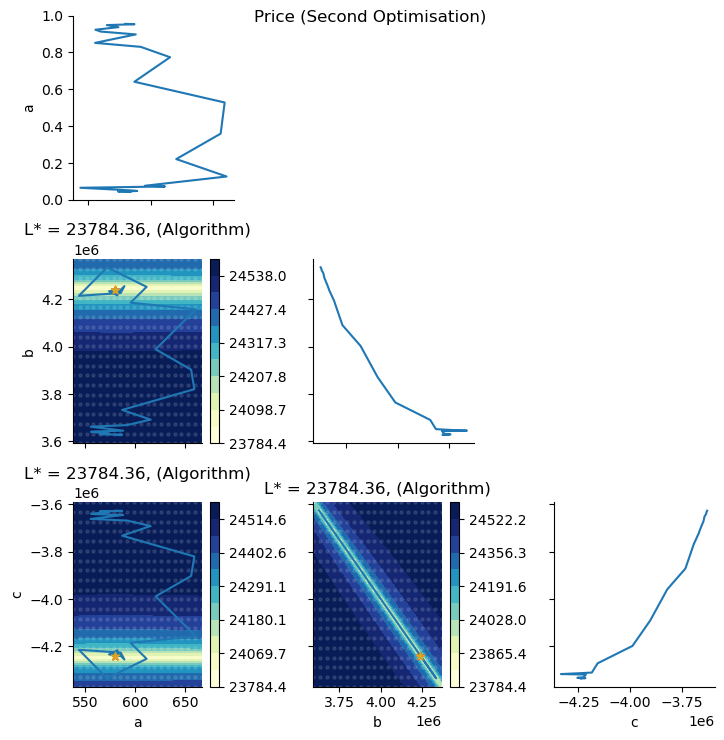

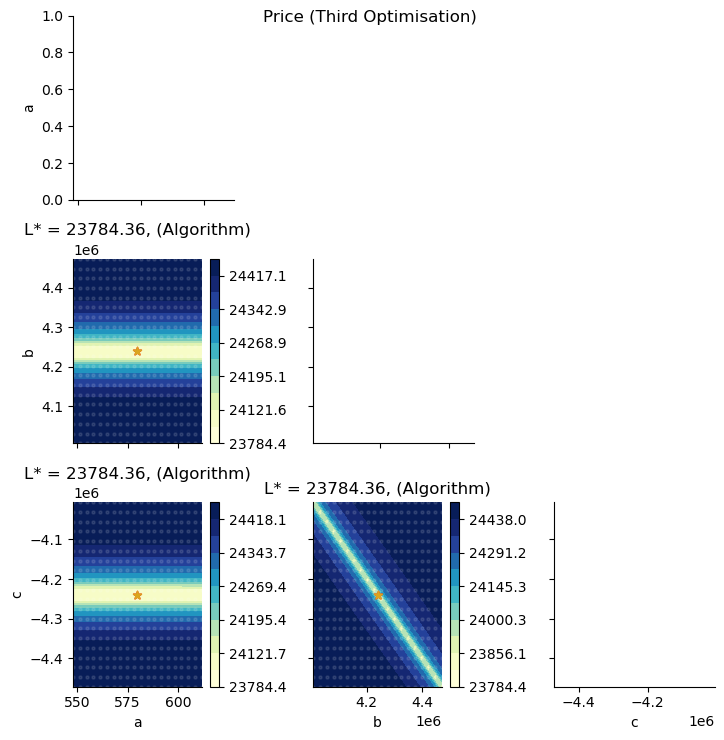

In [12]:
price = Prediction_Set(df)
res = price.optimise_likelihood(method='Differential Evolution')
res1 = price.optimise_likelihood(title='Price (Second Optimisation)', saveas='Price Optimisation Path.png')
res2 = price.optimise_likelihood(title='Price (Third Optimisation)', saveas='Price Optimisation Path2.png')

## Volume

             message: Optimization terminated successfully.
             success: True
                 fun: 21411.829488852156
                   x: [-5.100e+05  7.530e+05 -2.470e+05]
                 nit: 23
                nfev: 1244
          population: [[-5.276e+05  7.545e+05 -2.407e+05]
                       [-3.250e+05  6.879e+05 -2.605e+05]
                       ...
                       [-3.858e+05  6.199e+05 -2.466e+05]
                       [-9.340e+05  1.151e+06 -2.747e+05]]
 population_energies: [ 2.141e+04  2.182e+04 ...  2.193e+04  2.179e+04]
                 jac: [ 0.000e+00  0.000e+00  0.000e+00]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21395.38947713458
             x: [-4.523e+05  6.665e+05 -2.182e+05]
           nit: 135
          nfev: 281
 final_simplex: (array([[-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05]]), array([ 2.140e+04,  2.140e+04,  2.140e+04,  2.140e+04]))
       allvecs: [array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.100e+05,  7.530e+05, -2.470e+05]), array([-5.1

C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21395.38947713458
             x: [-4.523e+05  6.665e+05 -2.182e+05]
           nit: 104
          nfev: 216
 final_simplex: (array([[-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05],
                       [-4.523e+05,  6.665e+05, -2.182e+05]]), array([ 2.140e+04,  2.140e+04,  2.140e+04,  2.140e+04]))
       allvecs: [array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.523e+05,  6.665e+05, -2.182e+05]), array([-4.5

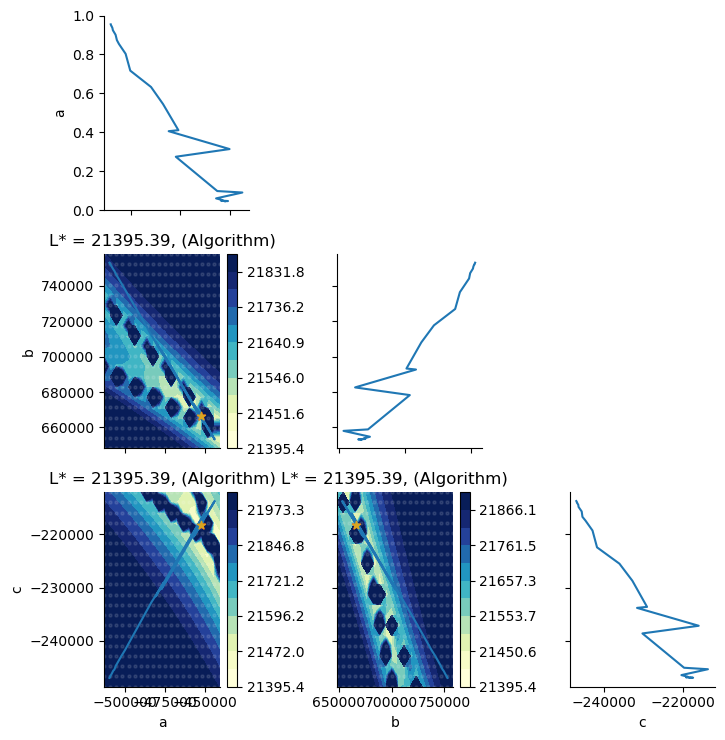

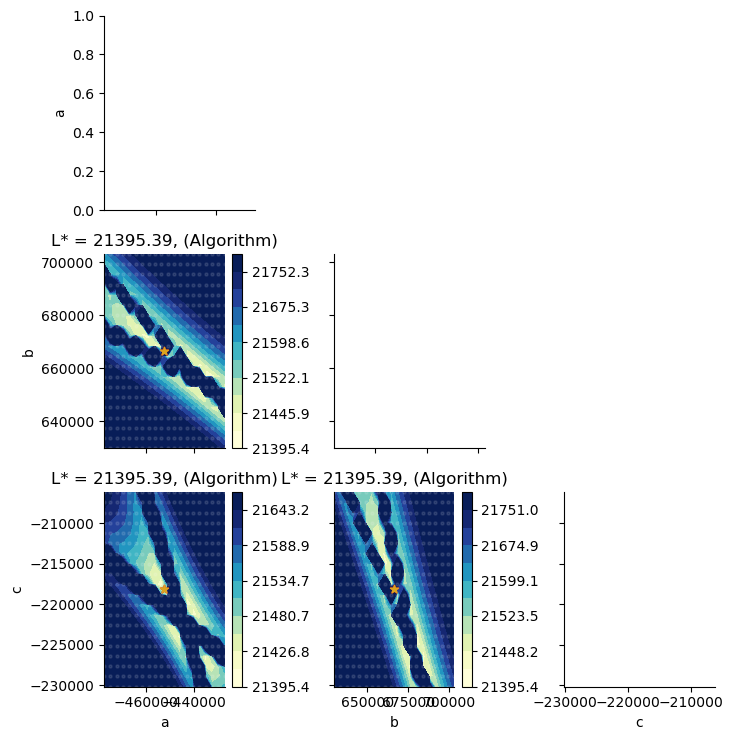

In [13]:
volume = Prediction_Set(vol_df)
res_vol = volume.optimise_likelihood(method='Differential Evolution')
res_vol1 = volume.optimise_likelihood(w0=res_vol.x)
res_vol2 = volume.optimise_likelihood()

In [14]:
price.apply_estimate()
volume.apply_estimate()

C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\177652109.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

## Expectation Maximisation

In [15]:
def set_std(row, df):
    if row.offset < 0:
        return 0
    filt = (df.offset == row.offset)&(df.period <= row.start) # Compare with already known points
    if np.sum(filt)==0:
        return row.Std
    x = df.loc[filt, 'value']
    mu = df.loc[filt, 'Observed']
    std = np.sqrt(np.sum((x-mu)**2)/len(x))
    return std

def set_val(row, df):
    if row.offset <0:
        return row.Observed

    filt = (df.period==row.period)&(df.offset>=row.offset)&(df.offset<=row.offset+10)
    if np.sum(filt)==0:
        return row.value
    x = df.loc[filt, 'value']
    std = df.loc[filt, 'Std']
    
    return np.sum(x/(std**2))/np.sum(std**-2)

def rmse(df, col1='value', col2='Observed'):
    preds = df.offset >=0
    return np.sqrt(((df.loc[preds, col1] - df.loc[preds, col2])**2).mean())


def expect_max(df, its=1, mses=[], dataset_name='', saveas=''):
    
    mses.append(rmse(df))
    dfs=[]
    for k in range(its):

        for row_i in df.index[df.offset >=0]:
            df = copy.deepcopy(df)
            df.loc[row_i, 'Std'] = set_std(df.loc[row_i], df)
            df.loc[row_i, 'value'] = np.maximum(set_val(df.loc[row_i], df), 0)
            dfs.append(df)
            
        mses.append(rmse(df))
        if mses[-1] > mses[-2]:
            break # Worsening performance, don't waste time continuing


    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(mses)
    ax[1].bar(range(len(mses)), scipy.stats.rankdata(mses))
    fig.suptitle(f'Progression of Performance\n{dataset_name}')
    ax[1].title.set_text("Ranking of RMSE")
    ax[0].title.set_text("RMSE")
    ax[0].set_ylabel("RMSE")
    ax[1].set_ylabel("Rank")

    ax[1].set_xticks(ticks=np.arange(len(mses)), labels=np.arange(len(mses))+1)
    ax[1].set_xlabel("Iterations")

    fig.tight_layout()

    if saveas:
        fig.savefig(saveas, dpi=300, bbox_inches='tight')
    return mses, df

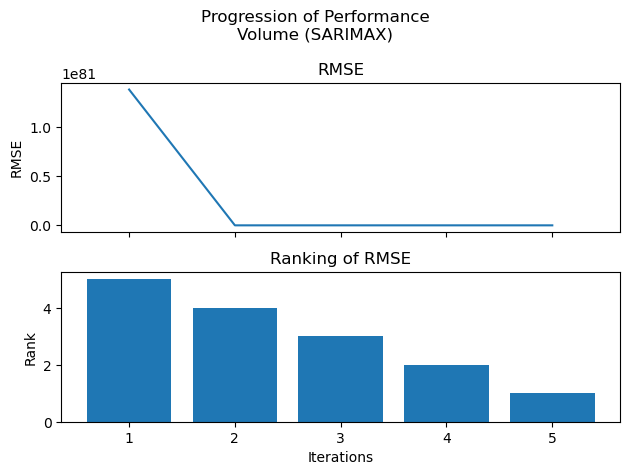

In [16]:
# Run Expectation Maximisation for predicted volume
mses, df_volume = expect_max(volume.df.dropna(), its=4, mses=[], dataset_name='Volume (SARIMAX)')

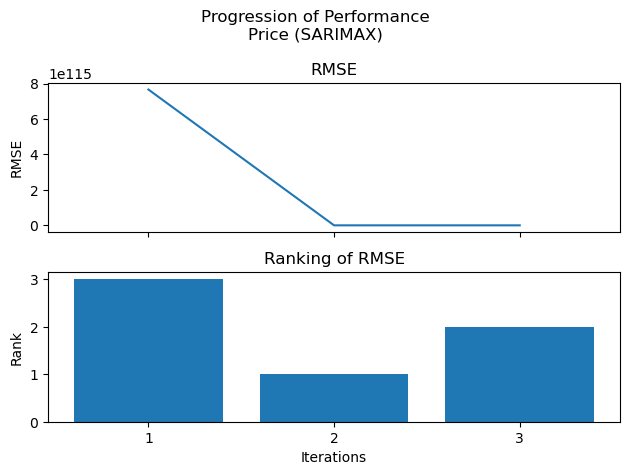

In [17]:
mses, price_df = expect_max(price.df.dropna(), its=4, mses=[], dataset_name='Price (SARIMAX)')

In [18]:
em_price = Prediction_Set(price_df)
em_volume = Prediction_Set(df_volume)

# Classifying higher prices

It is more important that the model accurately predicts whether price will be higher or lower than the starting time as this informs the purchase decision. The actual value does not matter.

In [19]:
def assign_higher(df, value_col='value', compare_col='Start Observed', res_col='Comparison', **kwargs):
    df[res_col] = 'No Comparison' # Initialising with a value that will be easy to identify if there are bugs
    df.loc[df[value_col]>df[compare_col], res_col] = 'Higher'  # Value will be higher than at the start of predictions
    df.loc[df[value_col]<df[compare_col], res_col] = 'Lower'  
    # Classify as same if 'close' - not just exactly equal
    df.loc[np.isclose(df[value_col],df[compare_col], **kwargs), res_col] = 'Same'  # kwargs passed so that tolerance can be changed

## Confusion matrices

In [20]:
from IPython.display import display

In [21]:
def make_confusion_matrix(obs, pred, ax_heatmap=None, ax_roc=None, save_as=None, labels=None, title="Confusion Matrix"):
    # Generate a confusion matrix and display it as a heatmap. Also show receiver operating curve
    conf_matrix = confusion_matrix(obs, pred, labels=labels)
    
    # Plot the confusion matrix as a heatmap
    #g = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', ax=ax_heatmap)
    g = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', ax=ax_heatmap, xticklabels=labels, yticklabels=labels)
    g.set_title(title)
    g.set_ylabel("Observations")
    g.set_xlabel("Predictions")

    
    
    results = sklearn.metrics.precision_recall_fscore_support(obs, pred, average='weighted', labels=labels)
    

    # Highlight diagonal cells
    for i in range(len(conf_matrix)):
        g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='greenyellow', lw=3))

    if ax_roc is not None:
        RocCurveDisplay.from_predictions(obs, pred, ax=ax_roc)
    if save_as is not None:
        plt.savefig(save_as, dpi=300)

    return results

def make_confusion_matrices(obs, preds, names, labels=None, mets = ["Precision", "Recall", "F-Score", "Support"]):
    results_df = pd.DataFrame(index=names, columns=mets)
    fig, ax = plt.subplots(len(names), figsize=(5, 5*len(names)))

    for i, (pred, name) in enumerate(zip(preds, names)):
        results_df.loc[name, :] = make_confusion_matrix(obs, pred, ax_heatmap=ax[i], labels=labels, title=name)
        
    display(results_df.style.highlight_max(axis=0, props='background-color:green;'))

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5563722027294108, 0.570820399113082, 0.5625189720027214, None)

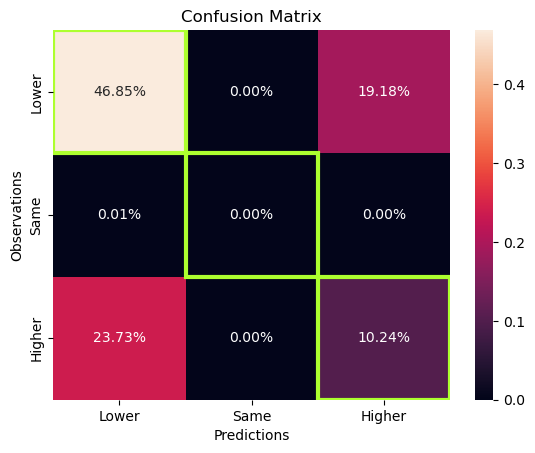

In [22]:
assign_higher(volume.prediction_df)
assign_higher(volume.prediction_df, value_col='Observed', res_col='Observed Comparison')
make_confusion_matrix(volume.prediction_df['Observed Comparison'], volume.prediction_df['Comparison'], labels=['Lower', 'Same', 'Higher'])

(0.5565536768623174, 0.570820399113082, 0.5626084887638554, None)

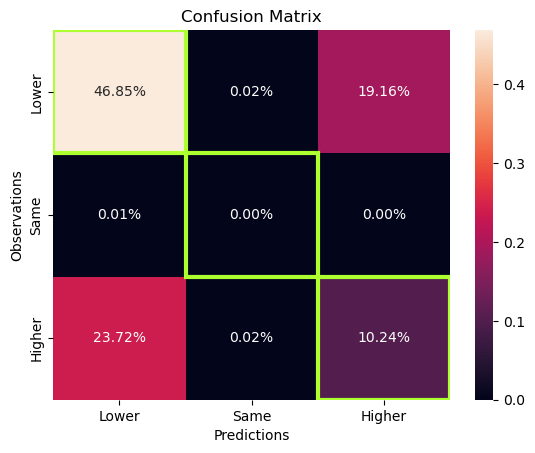

In [23]:

volume.prediction_df["Start Z-score"]
volume.prediction_df["Reference Zeros"] = 0

assign_higher(volume.prediction_df, value_col="Reference Zeros", compare_col="Start Z-score", res_col="New Comparison")
make_confusion_matrix(volume.prediction_df['Observed Comparison'], volume.prediction_df['New Comparison'], labels=['Lower', 'Same', 'Higher'])

In [24]:
def compare_approaches(obj):
    assign_higher(obj.prediction_df)
    assign_higher(obj.em.prediction_df)
    assign_higher(obj.prediction_df, value_col='Observed', res_col='Observed Comparison')
    
    obj.prediction_df["Start Z-score"] = (obj.prediction_df['Start Observed'] - obj.prediction_df['value'])/obj.prediction_df['Optimised Std']
    obj.prediction_df["Reference Zeros"] = 0
    assign_higher(obj.prediction_df, value_col="Reference Zeros", compare_col="Start Z-score", res_col="New Comparison")

    make_confusion_matrices(obj.prediction_df['Observed Comparison'], 
                            [obj.prediction_df['Comparison'], obj.prediction_df['New Comparison'], obj.em.prediction_df['Comparison']],
                              names=["Original", "Optimised", "EM"], labels=['Lower', 'Same', 'Higher'])


In [25]:
price.em = em_price
volume.em = Prediction_Set(df_volume)

In [26]:
em_price.prediction_df['Optimised Std'] = em_price.prediction_df['Std']

In [27]:
price.prediction_df

index        lower         upper        value  start  offset  period  \
10        10   -75.687426   4075.687426  2000.000000     10       0      10   
11        11 -2207.247631   6207.247631  2000.000000     10       1      11   
12        12 -4411.817367   8411.817367  2000.000000     10       2      12   
13        13 -6687.573032  10687.573032  2000.000000     10       3      13   
14        14 -9032.793902  13032.793902  2000.000000     10       4      14   
...      ...          ...           ...          ...    ...     ...     ...   
26206    166  4241.088122   5090.833684  4665.960903    165       1     166   
26207    167  4075.376597   5046.605095  4560.990846    165       2     167   
26374    166  4340.910318   5022.584046  4681.747182    166       0     166   
26375    167  4149.303170   4995.698088  4572.500629    166       1     167   
26543    167  4159.767061   4840.173626  4499.970344    167       0     167   

          Observed   Rank  Observed Rank  ...  Absolute Error  \
10     1500.000000   83.0           29.5  ...      500.000000   
11     1900.000000   83.0           58.0  ...      100.000000   
12     1550.000000   83.0           33.0  ...      450.000000   
13     1600.000000   83.0           36.5  ...      400.000000   
14     1600.000000   83.0           36.5  ...      400.000000   
...            ...    ...            ...  ...             ...   
26206  4630.000000  137.0          137.0  ...       35.960903   
26207  4499.970344  133.0          118.0  ...       61.020503   
26374  4630.000000  138.0          137.0  ...       51.747182   
26375  4499.970344  133.0          118.0  ...       72.530285   
26543  4499.970344  118.0          118.0  ...        0.000000   

       Absolute Rank Error          Std  Observation Z-score  Start Observed  \
10                    53.5  1059.024197            -0.472133          2000.0   
11                    25.0  2146.554914            -0.046586          2000.0   
12                    50.0  3271.335391            -0.137559          2000.0   
13                    46.5  4432.435220            -0.090244          2000.0   
14                    46.5  5628.976481            -0.071061          2000.0   
...                    ...          ...                  ...             ...   
26206                  0.0   216.771827            -0.165893          4600.0   
26207                 15.0   247.762372            -0.246286          4600.0   
26374                  1.0   173.896359            -0.297575          4615.0   
26375                 15.0   215.917071            -0.335917          4615.0   
26543                  0.0   173.573103             0.000000          4630.0   

       Higher  Optimised Std  New Z-score  Start Z-score  Observed Higher  
10      False   5.798209e+02    -0.862335       0.000000            False  
11      False   8.295197e+02    -0.120552       0.000000            False  
12      False   8.477238e+06    -0.000053       0.000000            False  
13      False   2.543362e+07    -0.000016       0.000000            False  
14      False   5.086832e+07    -0.000008       0.000000            False  
...       ...            ...          ...            ...              ...  
26206    True   8.295197e+02    -0.043351      -0.079517             True  
26207   False   8.477238e+06    -0.000007       0.000005            False  
26374    True   5.798209e+02    -0.089247      -0.115117             True  
26375   False   8.295197e+02    -0.087436       0.051234            False  
26543   False   5.798209e+02     0.000000       0.224258            False  

[10564 rows x 22 columns]

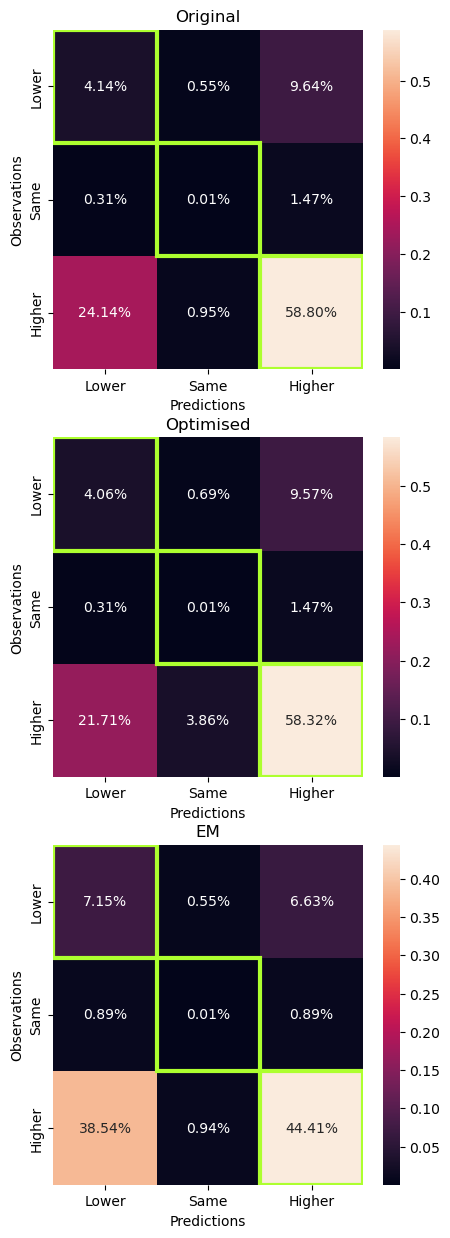

In [28]:
compare_approaches(price)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


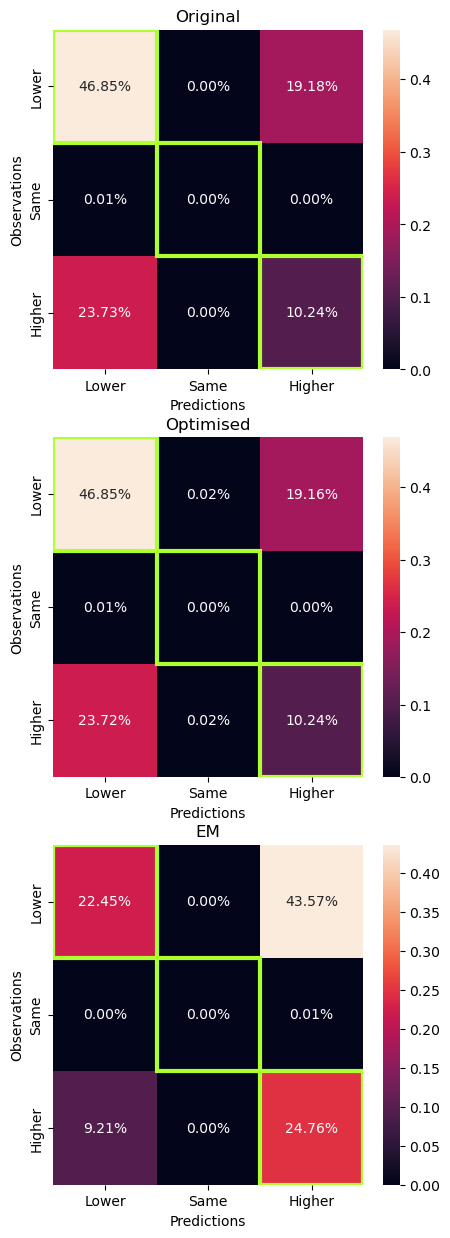

In [29]:
compare_approaches(volume)

In [30]:
price.prediction_df.columns

Index(['index', 'lower', 'upper', 'value', 'start', 'offset', 'period',
       'Observed', 'Rank', 'Observed Rank', 'error', 'rank_error',
       'Absolute Error', 'Absolute Rank Error', 'Std', 'Observation Z-score',
       'Start Observed', 'Higher', 'Optimised Std', 'New Z-score',
       'Start Z-score', 'Observed Higher', 'Comparison', 'Observed Comparison',
       'Reference Zeros', 'New Comparison'],
      dtype='object')

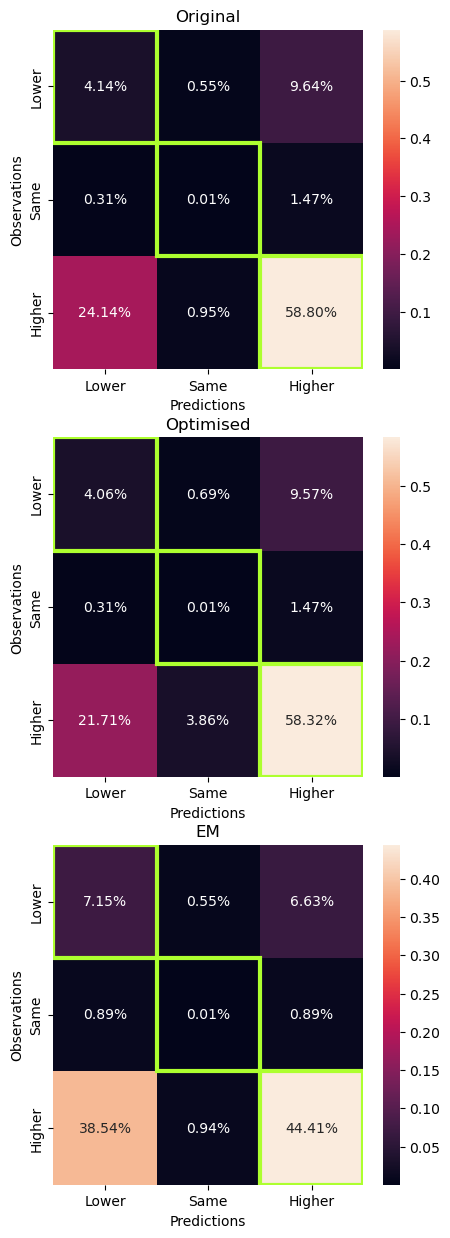

In [31]:
compare_approaches(price)

In [38]:
def zero_z(df, mu_col='value', std_col='Std'):
    df['Z Zero'] = -df[mu_col]/abs(df[std_col])
    return df[mu_col]/abs(df[std_col])

def probable_higher(df, mu_col='value', std_col='Std', compare_col='Start Observed', res_col='Probability Higher'):
    # Find probability that the predicted value is higher than the start value given that the value is positive
    z = -(df[compare_col].clip(lower=0) - df[mu_col])/abs(df[std_col])
    df['Z Start'] = z

    # Find probability that its positive given the prediction
    z_zero = zero_z(df, mu_col=mu_col, std_col=std_col)
    df['Z Zero'] = z_zero

    # Divide probability higher by probability positive
    df[res_col] = scipy.stats.norm.cdf(z)/scipy.stats.norm.cdf(zero_z(df, mu_col=mu_col, std_col=std_col))
    df.loc[np.isneginf(df[res_col]), res_col] = 0
    df.loc[np.isposinf(df[res_col]), res_col] = 1

    #plot_probability(df, res_col, ax=None)

def plot_probability(df, res_col, ax=None):
    sns.histplot(df.replace([np.inf, -np.inf], np.nan).dropna(), x=res_col, hue="Observed Comparison", multiple='fill')



In [41]:
probable_higher(volume.prediction_df)

0
              value          Std  Start Observed   Z Start    Z Zero
10      2480.554183   999.981625           499.6  1.980991  2.480600
11     11941.300214  1999.963250           499.6  5.720955  5.970760
12      6441.888277  2999.944874           499.6  1.980799  2.147336
13     10236.268750  3999.926499           499.6  2.434212  2.559114
14     -7315.054944  4999.908124           499.6 -1.562960 -1.463038
...             ...          ...             ...       ...       ...
26206    465.740201   927.616796            50.5  0.447642  0.502083
26207   1066.701576   965.769822            50.5  1.052219  1.104509
26374    534.209888   831.188429           561.7 -0.033073  0.642706
26375   1105.793565   914.930952           561.7  0.594683  1.208609
26543   1096.146360   826.963267           526.7  0.688599  1.325508

[11275 rows x 5 columns]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\3374576941.py:13: RuntimeWarning: invalid value encountered in divide
  df[res_col] = scipy.stats.norm.cdf(z)/scipy.stats.norm.cdf(zero_z(df, mu_col=mu_col, std_col=std_col))


In [42]:
volume.prediction_df

index         lower         upper         value  start  offset  period  \
10        10    520.590199   4440.518168   2480.554183     10       0      10   
11        11   8021.372245  15861.228183  11941.300214     10       1      11   
12        12    561.996323  12321.780231   6441.888277     10       2      12   
13        13   2396.412811  18076.124688  10236.268750     10       3      13   
14        14 -17114.874867   2484.764979  -7315.054944     10       4      14   
...      ...           ...           ...           ...    ...     ...     ...   
26206    166  -1352.388719   2283.869121    465.740201    165       1     166   
26207    167   -826.207274   2959.610426   1066.701576    165       2     167   
26374    166  -1094.919432   2163.339208    534.209888    166       0     166   
26375    167   -687.471102   2899.058231   1105.793565    166       1     167   
26543    167   -524.701642   2716.994362   1096.146360    167       0     167   

         Observed   Rank  Observed Rank  ...  Start Z-score  Observed Higher  \
10     1555.00000  163.0          128.0  ...      -0.004380             True   
11      992.40000  168.0          102.0  ...      -2.909482             True   
12     1452.90000  166.0          122.0  ...      -0.740412             True   
13      948.80000  167.0           97.0  ...      -0.023384             True   
14      832.20000  154.0           91.0  ...       0.006119             True   
...           ...    ...            ...  ...            ...              ...   
26206   526.70000   48.0           53.0  ...      -0.105590             True   
26207  1096.14636  105.0          107.0  ...      -0.126619             True   
26374   526.70000   54.0           53.0  ...       0.000061            False   
26375  1096.14636  108.0          107.0  ...      -0.138356             True   
26543  1096.14636  107.0          107.0  ...      -0.001259             True   

       Comparison  Observed Comparison  Reference Zeros  New Comparison  \
10         Higher               Higher                0          Higher   
11         Higher               Higher                0          Higher   
12         Higher               Higher                0          Higher   
13         Higher               Higher                0          Higher   
14          Lower               Higher                0           Lower   
...           ...                  ...              ...             ...   
26206      Higher               Higher                0          Higher   
26207      Higher               Higher                0          Higher   
26374       Lower                Lower                0           Lower   
26375      Higher               Higher                0          Higher   
26543      Higher               Higher                0          Higher   

        Z Start    Z Zero  Probability Higher  Adjusted Probability Higher  
10     1.980991 -2.480600            0.982648                     0.982648  
11     5.720955 -5.970760            1.000000                     1.000000  
12     1.980799 -2.147336            0.991949                     0.991949  
13     2.434212 -2.559114            0.997773                     0.997773  
14    -1.562960  1.463038            0.822979                     0.822979  
...         ...       ...                 ...                          ...  
26206  0.447642 -0.502083            0.971972                     0.383212  
26207  1.052219 -1.104509            0.986521                     0.378893  
26374 -0.033073 -0.642706            0.658033                     0.321254  
26375  0.594683 -1.208609            0.816577                     0.430179  
26543  0.688599 -1.325508            0.831365                     0.434401  

[11275 rows x 30 columns]

In [45]:
probable_higher(price.prediction_df, std_col='Optimised Std')

0
             value  Optimised Std  Start Observed   Z Start    Z Zero
10     2000.000000   5.798209e+02          2000.0 -0.000000  3.449341
11     2000.000000   8.295197e+02          2000.0 -0.000000  2.411034
12     2000.000000   8.477238e+06          2000.0 -0.000000  0.000236
13     2000.000000   2.543362e+07          2000.0 -0.000000  0.000079
14     2000.000000   5.086832e+07          2000.0 -0.000000  0.000039
...            ...            ...             ...       ...       ...
26206  4665.960903   8.295197e+02          4600.0  0.079517  5.624895
26207  4560.990846   8.477238e+06          4600.0 -0.000005  0.000538
26374  4681.747182   5.798209e+02          4615.0  0.115117  8.074471
26375  4572.500629   8.295197e+02          4615.0 -0.051234  5.512227
26543  4499.970344   5.798209e+02          4630.0 -0.224258  7.760966

[10564 rows x 5 columns]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_19024\3374576941.py:13: RuntimeWarning: invalid value encountered in divide
  df[res_col] = scipy.stats.norm.cdf(z)/scipy.stats.norm.cdf(zero_z(df, mu_col=mu_col, std_col=std_col))


In [36]:
price.prediction_df['Observed Higher'] = price.prediction_df['Observed'] > price.prediction_df['Start Observed']

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered

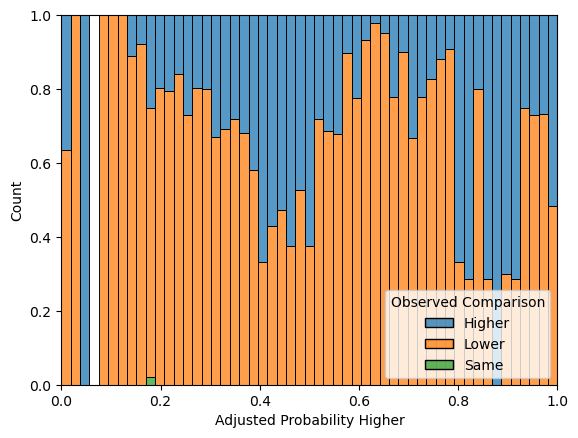

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered

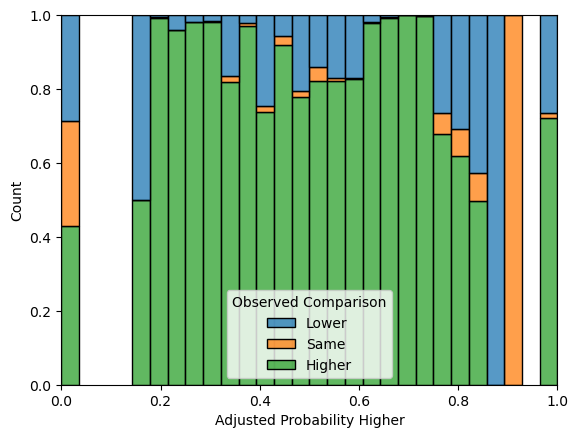

In [47]:
def find_prob(row, df, col= 'Probability Higher'):
    filt = df.period < row.start
    if sum(filt) < 20:
        return row[col]

    diff_probs = abs(df[col] - row[col])
    within_range = filt & (diff_probs <= 0.1) #diff_probs.loc[filt].quantile(0.1)

    
    try:
        #return np.average(df.loc[within_range, 'Observed Higher'], weights=abs(1/df.loc[within_range, col]))
        return np.average(df.loc[within_range, 'Observed Higher'])
    except:
        return row[col]

# for row_i in price.prediction_df.index:
    
#     price.prediction_df.loc[row_i, "Adjusted Probability Higher"] = find_prob(price.prediction_df.loc[row_i],price.prediction_df)

def find_prob_obj(df):
    for row_i in df.index:
        df.loc[row_i, "Adjusted Probability Higher"] = find_prob(df.loc[row_i],df)

    plot_probability(df, "Adjusted Probability Higher", ax=None)


find_prob_obj(volume.prediction_df)

plt.show()
find_prob_obj(price.prediction_df)


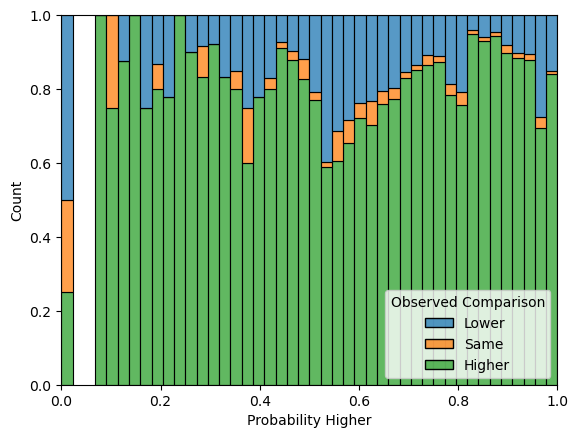

In [ ]:
plot_probability(price.prediction_df, "Probability Higher", ax=None)

In [ ]:
price.prediction_df['Higher'] =price.prediction_df['Higher'].astype(int)
rmse(price.prediction_df, 'Higher', 'Observed Higher')

0.6014937860913864

In [ ]:
rmse(price.prediction_df, 'Probability Higher', 'Observed Higher')

0.4462413544097757

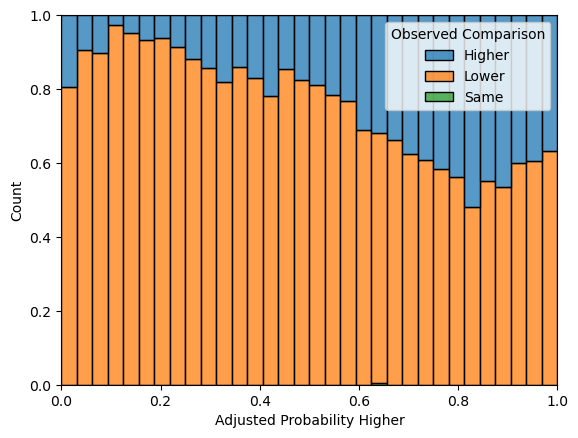

In [ ]:
plot_probability(volume.prediction_df, "Adjusted Probability Higher", ax=None)

# Save Results

In [ ]:

full_df_volume = volume.df
full_df_volume.loc[full_df_volume.offset>=0] = df_volume

full_df_volume[['index', 'lower', 'upper', 'value', 'start', 'offset', 'period', 'Std']].to_csv("Adjusted Volume.csv")

full_df_price = price.df
full_df_price["Probability Higher"] = 0.5
full_df_price.loc[full_df_price.offset>=0] = price.prediction_df
full_df_price.Higher = full_df_price.Higher.astype(bool)

full_df_price[['index', 'lower', 'upper', 'value', 'start', 'offset', 'period', 'Std', 'Higher', 'Probability Higher']].to_csv("Adjusted Price.csv")